0. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Input,Dropout,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

1. Load data 

In [2]:
df = pd.read_csv('./dog_data/labels.csv')

df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [3]:
df.shape

(10222, 2)

In [4]:
df["breed"].nunique()

120

In [5]:
df["breed"].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [6]:
df.isna().sum()

id       0
breed    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


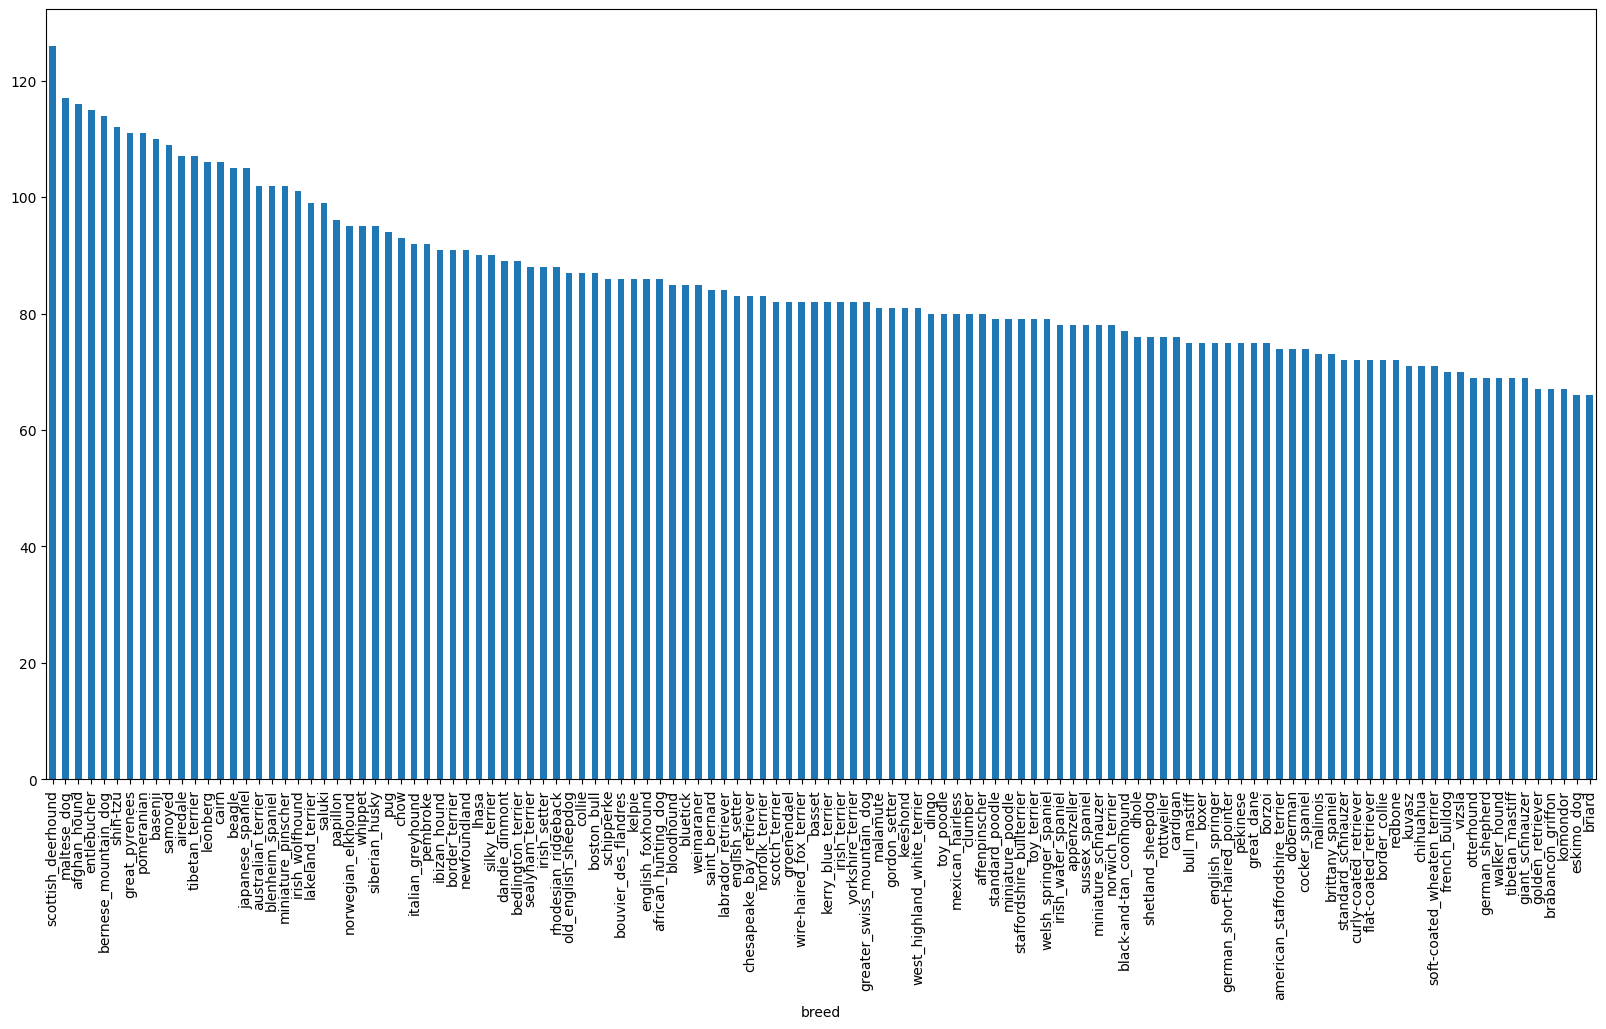

In [8]:
df["breed"].value_counts().plot.bar(figsize=(20, 10));

2. Select representative varieties

In [9]:
breed_counts = df['breed'].value_counts()
included_breeds = breed_counts[breed_counts > 100].index.tolist()
df = df[df['breed'].isin(included_breeds)].reset_index(drop=True)

In [10]:
df.shape

(2184, 2)

In [11]:
df.head()

id               breed
0  003df8b8a8b05244b1d920bb6cf451f9             basenji
1  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound
2  00693b8bc2470375cc744a6391d397ec         maltese_dog
3  00bee065dcec471f26394855c5c2f3de               cairn
4  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier

In [12]:
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

In [13]:
image_dir = "./dog_data/train/"

In [14]:
resized_images = []
for idx, filename in enumerate(df['id']):
    img_path = os.path.join(image_dir, filename + '.jpg')
    resized_img = read_and_resize_image_rgb(img_path)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

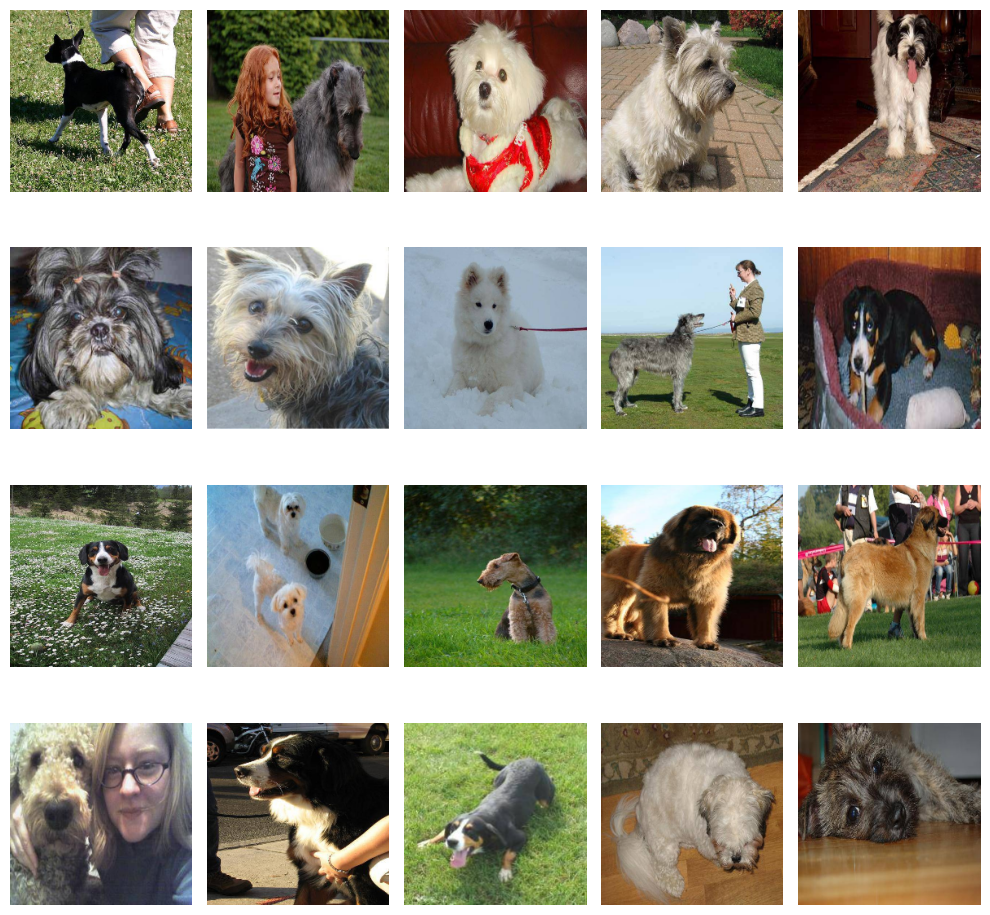

In [15]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(resized_images_array[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
class_names = df['breed'].unique()
class_names[1:10]

array(['scottish_deerhound', 'maltese_dog', 'cairn', 'tibetan_terrier',
       'shih-tzu', 'australian_terrier', 'samoyed', 'entlebucher',
       'airedale'], dtype=object)

In [17]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

In [18]:
X = resized_images_array
y = new_labels

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=30)

In [20]:
X_train.shape

(1856, 224, 224, 3)

In [21]:
X_test.shape

(328, 224, 224, 3)

In [22]:
y_train.shape

(1856, 20)

In [23]:
y_test.shape

(328, 20)

In [24]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

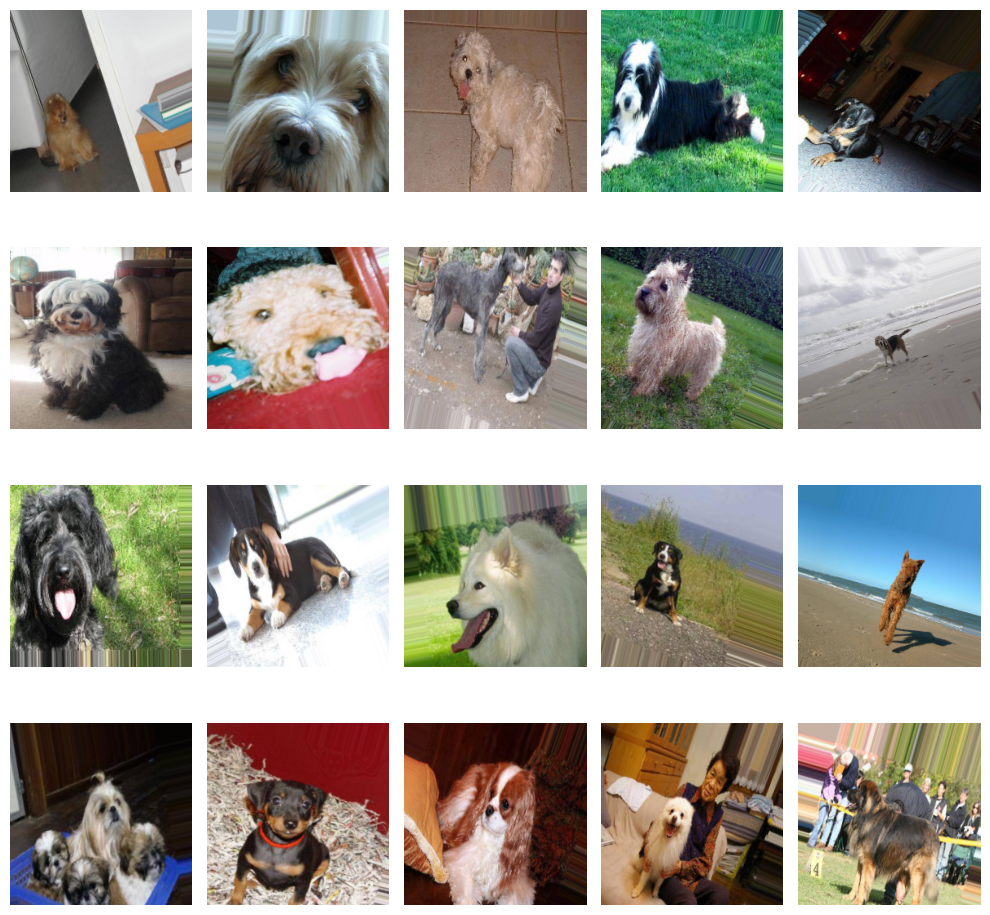

In [25]:
augmented_images = train_datagen.flow(X_train, y=y_train, shuffle=True)
plt.figure(figsize=(10, 10))
for i in range(20):
    augmented_image = augmented_images.next()[0][0] 
    plt.subplot(4, 5, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
training_set=train_datagen.flow(X_train,y=y_train,batch_size=64)
testing_set=test_datagen.flow(X_test,y=y_test,batch_size=64)

In [27]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='sigmoid'),
    Dropout(0.2),
    Dense(20, activation='softmax')
])

In [28]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [30]:
history=model.fit_generator(training_set,validation_data = testing_set,epochs = 10)

Epoch 1/10


29/29 [==============================] - 18s 603ms/step - loss: 3.0463 - accuracy: 0.0496 - val_loss: 2.9961 - val_accuracy: 0.0823
Epoch 2/10
29/29 [==============================] - 17s 585ms/step - loss: 2.9743 - accuracy: 0.0803 - val_loss: 2.9689 - val_accuracy: 0.0854
Epoch 3/10
29/29 [==============================] - 17s 591ms/step - loss: 2.9447 - accuracy: 0.0878 - val_loss: 2.8544 - val_accuracy: 0.1463
Epoch 4/10
29/29 [==============================] - 17s 600ms/step - loss: 2.8635 - accuracy: 0.1212 - val_loss: 2.8116 - val_accuracy: 0.1220
Epoch 5/10
29/29 [==============================] - 17s 591ms/step - loss: 2.7930 - accuracy: 0.1336 - val_loss: 2.7155 - val_accuracy: 0.1921
Epoch 6/10
29/29 [==============================] - 16s 566ms/step - loss: 2.7604 - accuracy: 0.1530 - val_loss: 2.6969 - val_accuracy: 0.1738
Epoch 7/10
29/29 [==============================] - 16s 566ms/step - loss: 2.7033 - accuracy: 0.1584 - val_loss: 2.6533 - val_accuracy: 0.17

In [31]:
df = pd.read_csv('./dog_data/labels.csv')
df.shape

(10222, 2)

In [32]:
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

In [33]:
resized_images = []
for idx, filename in enumerate(df['id']):
    img_path = os.path.join(image_dir, filename + '.jpg')
    resized_img = read_and_resize_image_rgb(img_path)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

In [34]:
class_names = df['breed'].unique()

In [35]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

In [36]:
X = resized_images_array
y = new_labels

In [37]:
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

In [38]:
effnet_preprocessor = tf.keras.applications.efficientnet.preprocess_input
effnet_features = get_features(EfficientNetB4, effnet_preprocessor, (224, 224, 3), X)

xception_preprocessor = tf.keras.applications.xception.preprocess_input
xception_features = get_features(Xception, xception_preprocessor, (224, 224, 3), X)

resnet_preprocessor = tf.keras.applications.resnet50.preprocess_input
resnet_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), X)

320/320 [==============================] - 441s 1s/step
Feature maps shape: (10222, 1792)
320/320 [==============================] - 336s 1s/step
Feature maps shape: (10222, 2048)
320/320 [==============================] - 400s 1s/step
Feature maps shape: (10222, 2048)


In [39]:
final_features = np.concatenate([effnet_features, xception_features, resnet_features], axis=-1)
print('Final feature maps shape:', final_features.shape)

Final feature maps shape: (10222, 5888)


In [40]:
model = Sequential()
model.add(Dropout(0.5, input_shape=(final_features.shape[1],)))
model.add(Dense(120, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [42]:
history = model.fit(final_features, y,
                    batch_size=64,
                    epochs=50,
                    validation_split=0.15,
                    callbacks=[early_stopping])

Epoch 1/50
136/136 [==============================] - 2s 9ms/step - loss: 1.3197 - accuracy: 0.6744 - val_loss: 0.4863 - val_accuracy: 0.8507
Epoch 2/50
136/136 [==============================] - 1s 8ms/step - loss: 0.3771 - accuracy: 0.8812 - val_loss: 0.4988 - val_accuracy: 0.8501
Epoch 3/50
136/136 [==============================] - 1s 7ms/step - loss: 0.2322 - accuracy: 0.9233 - val_loss: 0.4764 - val_accuracy: 0.8585
Epoch 4/50
136/136 [==============================] - 1s 7ms/step - loss: 0.1553 - accuracy: 0.9490 - val_loss: 0.4638 - val_accuracy: 0.8774
Epoch 5/50
136/136 [==============================] - 1s 7ms/step - loss: 0.1094 - accuracy: 0.9641 - val_loss: 0.4724 - val_accuracy: 0.8657
Epoch 6/50
136/136 [==============================] - 1s 7ms/step - loss: 0.0844 - accuracy: 0.9743 - val_loss: 0.4521 - val_accuracy: 0.8735
Epoch 7/50
136/136 [==============================] - 1s 7ms/step - loss: 0.0639 - accuracy: 0.9826 - val_loss: 0.4544 - val_accuracy: 0.8657
Epoch 

In [43]:
all_predictions = model.predict(final_features)
all_predicted_labels = np.argmax(all_predictions, axis=1)
true_labels = np.argmax(y, axis=1)

320/320 [==============================] - 1s 1ms/step


6. Model training

In [44]:
random.seed(6)
random_indices = random.sample(range(len(resized_images)), 20)

In [45]:
def plot_images(images, predicted_labels, true_labels, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        pred_label = predicted_labels[i]
        true_label = true_labels[i]
        if pred_label == true_label:
            title_color = 'green'
        else:
            title_color = 'red'
        plt.title(f"Predicted: {pred_label}\nTrue: {true_label}", color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [46]:
images_random_20 = [resized_images[i] for i in random_indices]
predicted_labels_random_20 = all_predicted_labels[random_indices]
true_labels_random_20 = true_labels[random_indices]

In [47]:
predicted_labels_names = label_encoder.inverse_transform(predicted_labels_random_20)
true_labels_names = label_encoder.inverse_transform(true_labels_random_20)

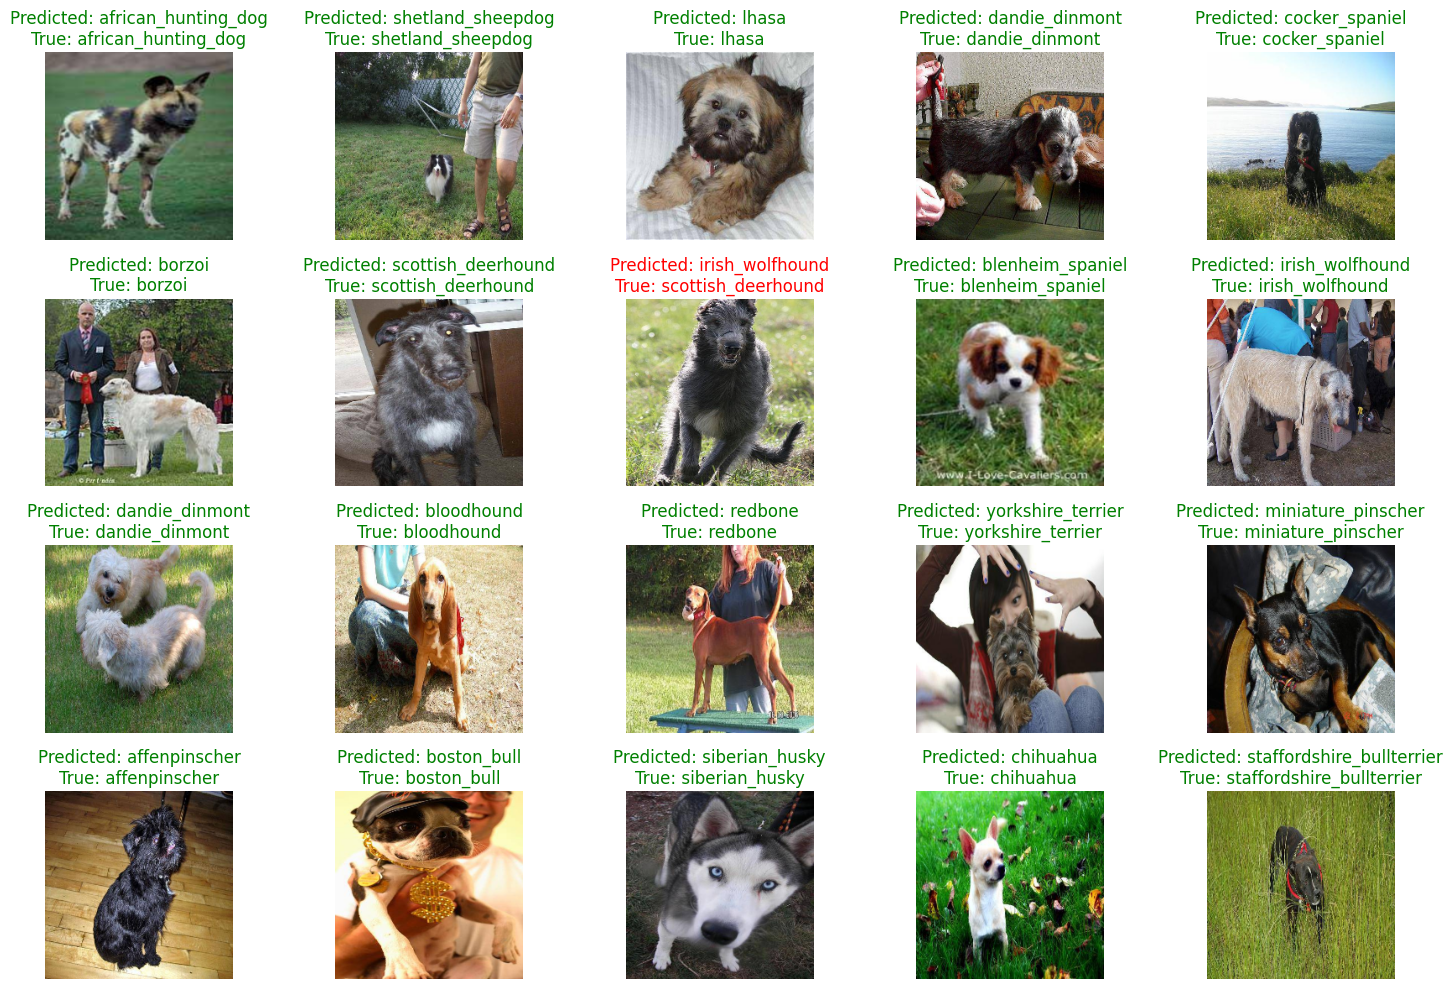

In [48]:
plot_images(images_random_20, predicted_labels_names, true_labels_names, class_names)

추가적 시각화

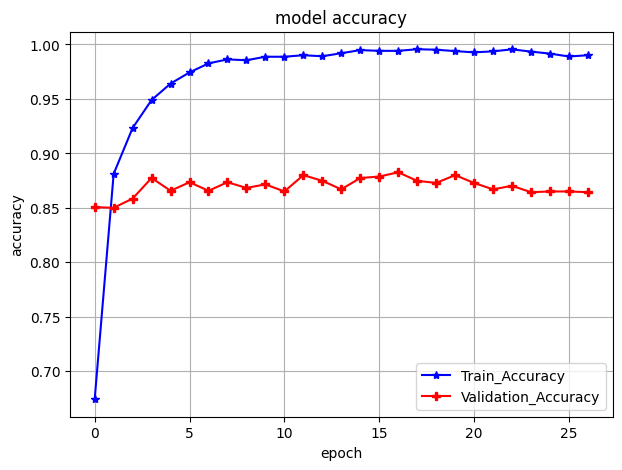

In [49]:
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'],label="Train_Accuracy",color="blue",marker="*")
plt.plot(history.history['val_accuracy'],label="Validation_Accuracy",color="red",marker="P")
plt.grid(True)
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

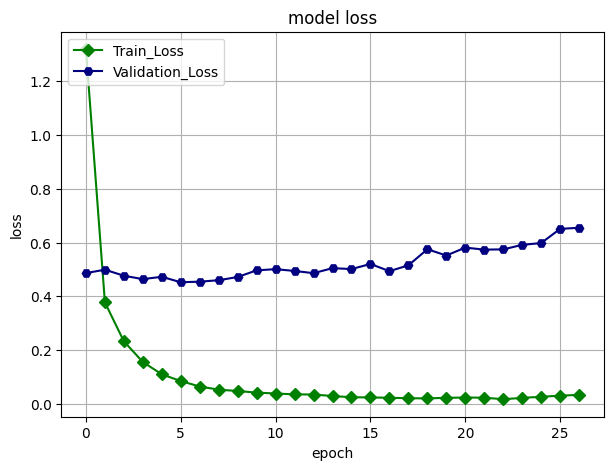

In [50]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'],color="green",marker="D")
plt.plot(history.history['val_loss'],color="navy",marker="H")
plt.grid(True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train_Loss', 'Validation_Loss'], loc='upper left')
plt.show()

In [51]:
lab = df["breed"].unique().tolist()
print(lab)

['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound', 'shetland_sheepdog', 'walker_hound', 'maltese_dog', 'norfolk_terrier', 'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer', 'doberman', 'otterhound', 'standard_schnauzer', 'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn', 'affenpinscher', 'labrador_retriever', 'ibizan_hound', 'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael', 'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier', 'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz', 'german_shepherd', 'greater_swiss_mountain_dog', 'basset', 'australian_terrier', 'schipperke', 'rhodesian_ridgeback', 'irish_setter', 'appenzeller', 'bloodhound', 'samoyed', 'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon', 'border_collie', 'entlebucher', 'collie', 'malamute', 'welsh_springer_spaniel', 'chihuahua', 'saluki', 'pug', 'malino

In [52]:
best_epoch = np.argmin(history.history['val_loss'])  # 또는 'val_accuracy' 등 성능 지표에 따라 선택

In [53]:
all_predictions = model.predict(final_features)
all_predicted_labels = np.argmax(all_predictions, axis=1)
true_labels = np.argmax(y, axis=1)

320/320 [==============================] - 0s 1ms/step


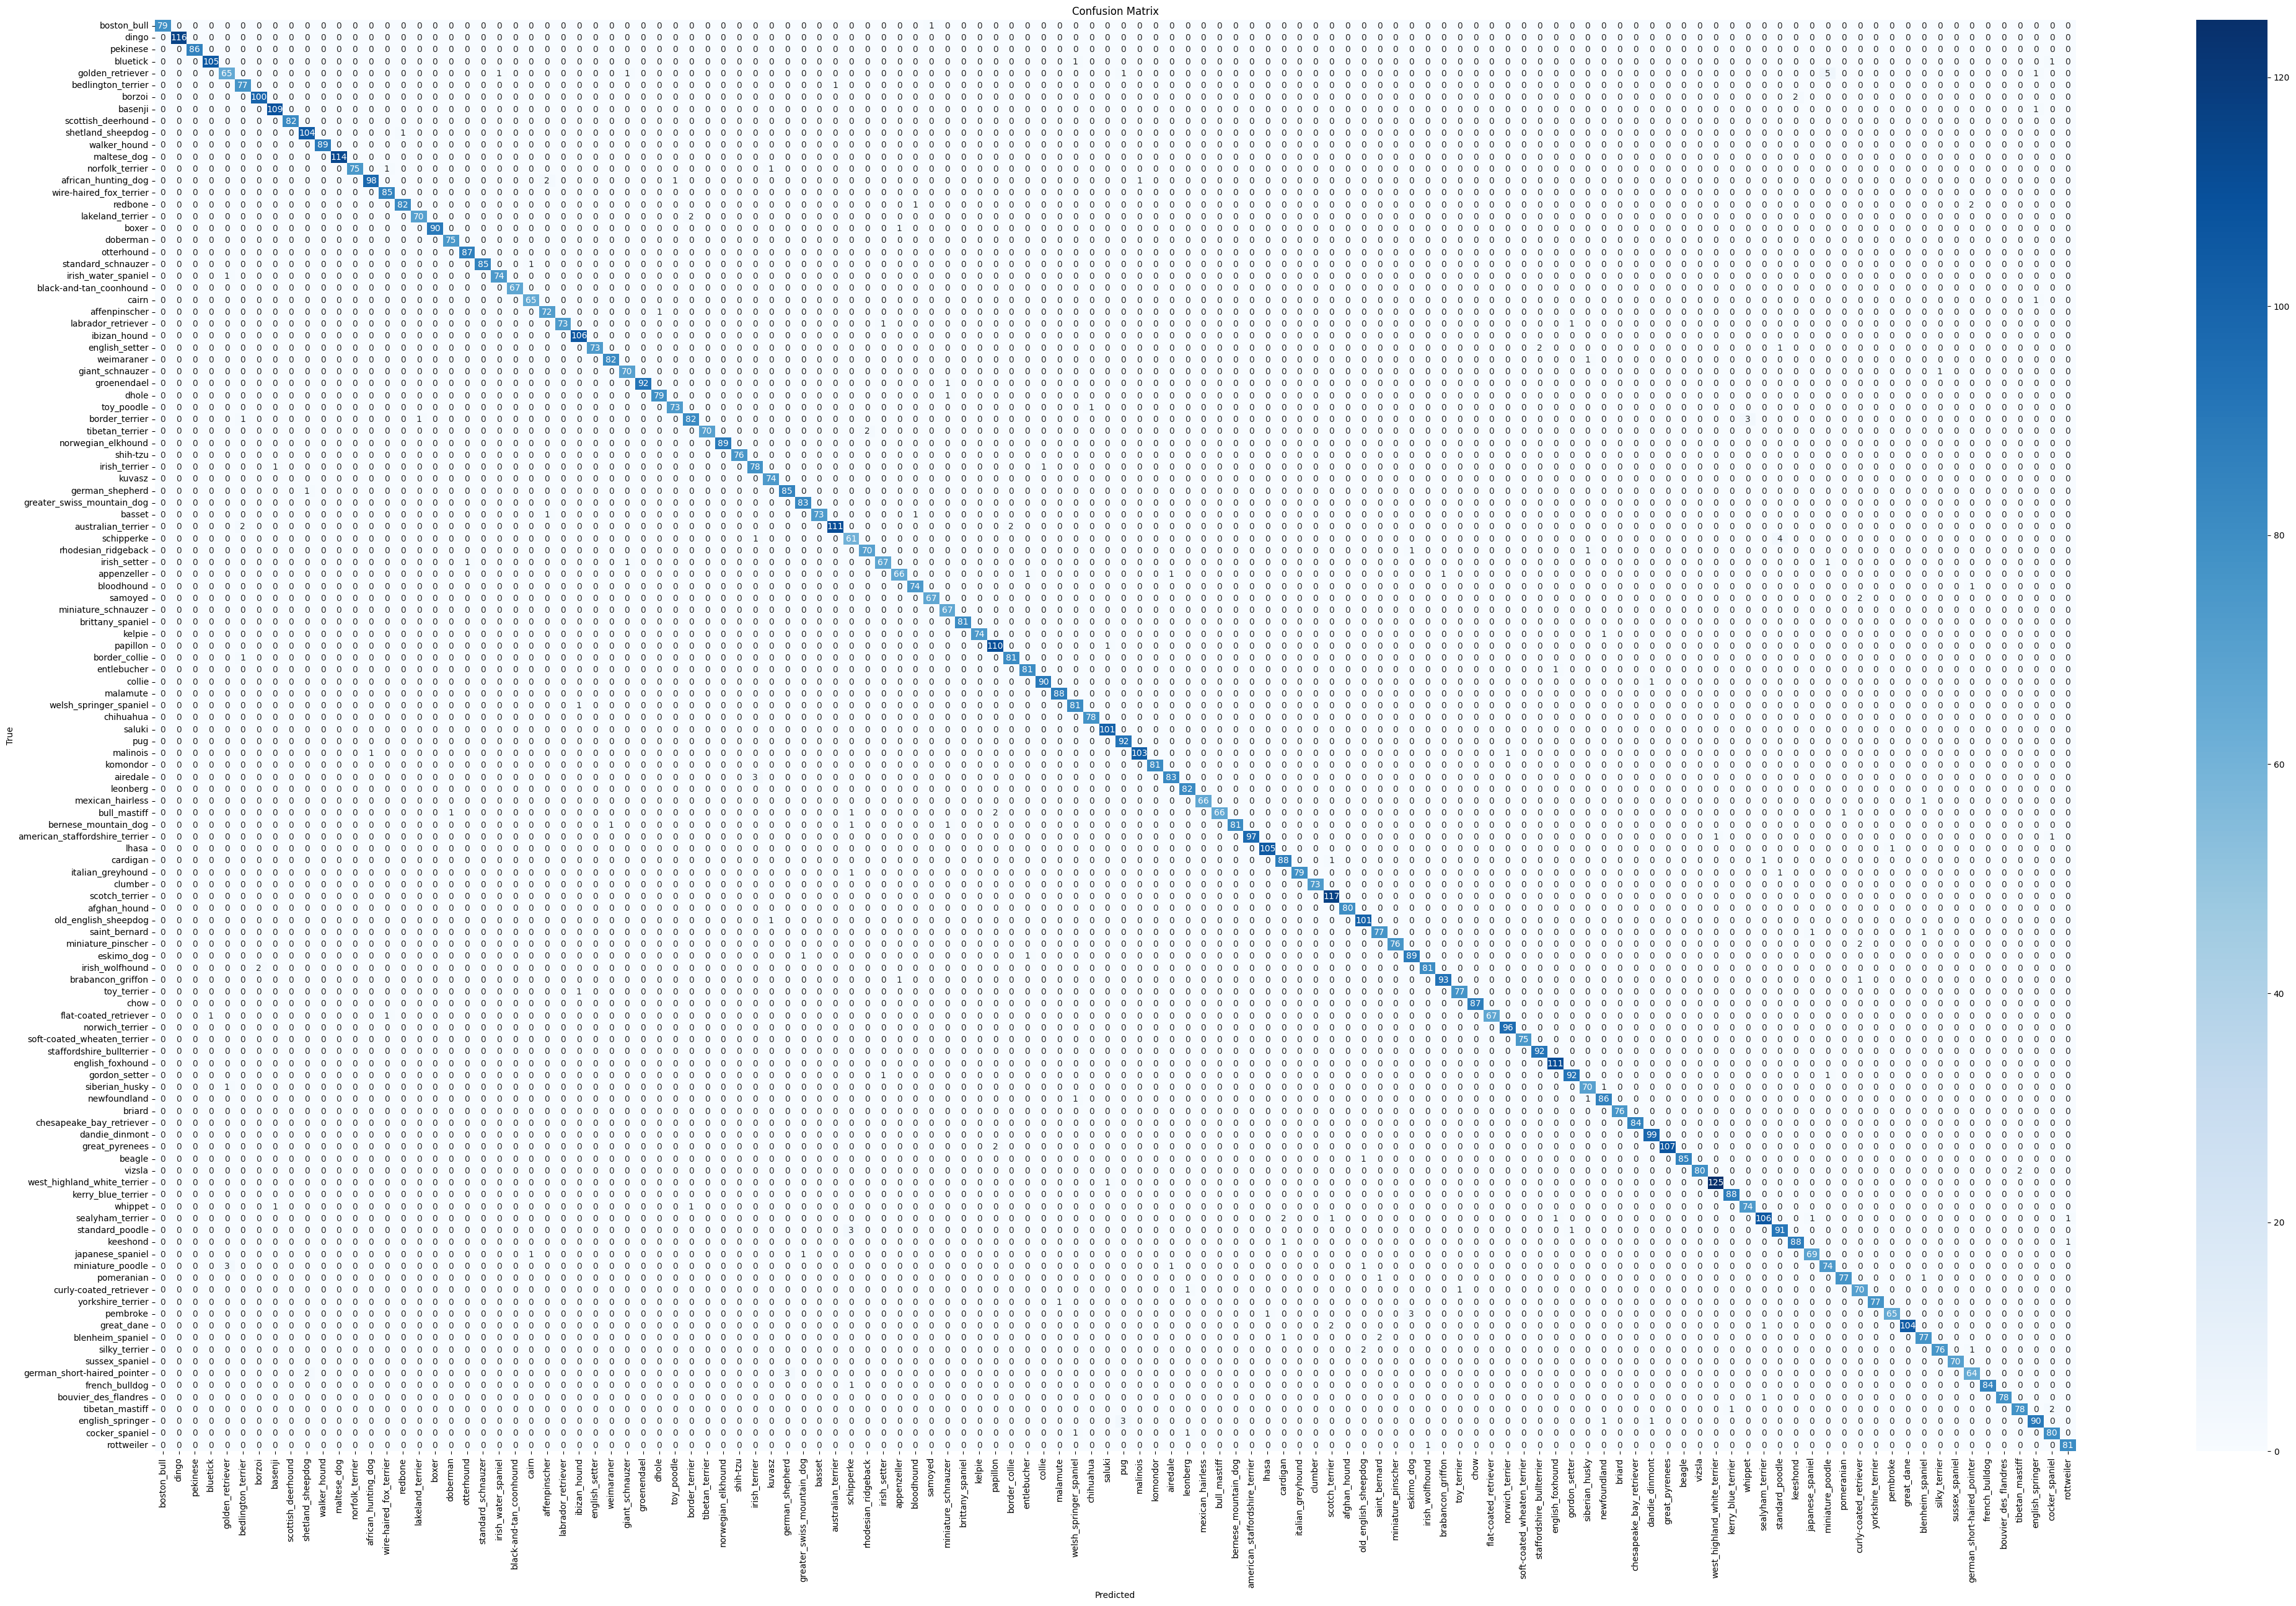

In [54]:
conf_matrix = confusion_matrix(true_labels, all_predicted_labels)

plt.figure(figsize=(50, 30))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [55]:
pre=model.predict(testing_set)
predict=np.argmax(pre,axis=1)

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_2/Tensordot/MatMul defined at (most recent call last):
  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 518, in process_one

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 766, in execute_request

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "C:\Users\juneh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\juneh\AppData\Local\Temp\ipykernel_9156\2305772518.py", line 1, in <module>

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\juneh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py", line 244, in call

Matrix size-incompatible: In[0]: [3211264,3], In[1]: [5888,120]
	 [[{{node sequential_1/dense_2/Tensordot/MatMul}}]] [Op:__inference_predict_function_62990]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predict,target_names=class_names))